In [1]:
!pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 4.4 MB/s eta 0:00:0000:01


# Import thư viện và một số cài đặt

In [2]:
# ============================
# CELL 1 — Import & Config
# ============================

import os
from glob import glob
import numpy as np
import mne
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from hmmlearn import hmm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm import tqdm

# Config
BASE_PATH = "/kaggle/input/eeg-oddball/EEG"
TMIN, TMAX = -0.2, 0.8
FMIN, FMAX = 0.1, 20
P300_WINDOW = (0.25, 0.35)
RANDOM_STATE = 42
BATCH_SIZE = 64
EPOCHS = 30
LEARNING_RATE = 1e-3
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", DEVICE)

# List subjects
subject_dirs = sorted(glob(os.path.join(BASE_PATH, "sub*")))
print("Found subjects:", len(subject_dirs))


Device: cuda
Found subjects: 42


# Preprocessing

## Đọc dữ liệu (sub 01)

In [3]:
subject_folder = "/kaggle/input/eeg-oddball/EEG/sub 01" 
vhdr = glob(os.path.join(subject_folder, "*.vhdr"))[0]

raw = mne.io.read_raw_brainvision(vhdr, preload=True)

Extracting parameters from /kaggle/input/eeg-oddball/EEG/sub 01/sub-01_task-oddball_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 1371319  =      0.000 ...  1371.319 secs...


In [4]:
raw

<RawBrainVision | sub-01_task-oddball_eeg.eeg, 127 x 1371320 (1371.3 s), ~1.30 GiB, data loaded>

Using matplotlib as 2D backend.


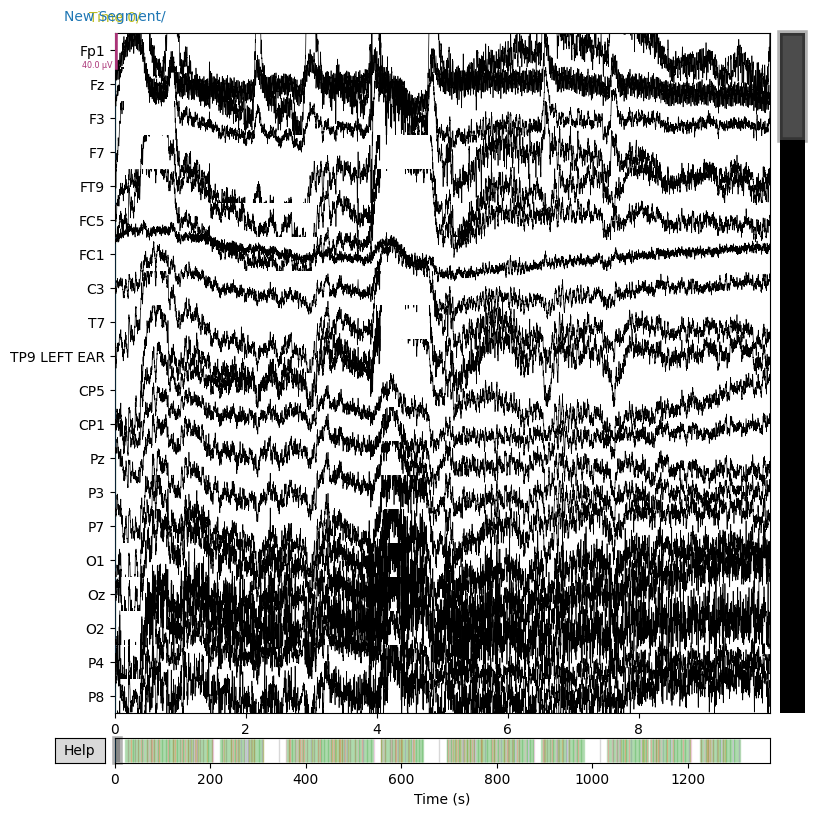

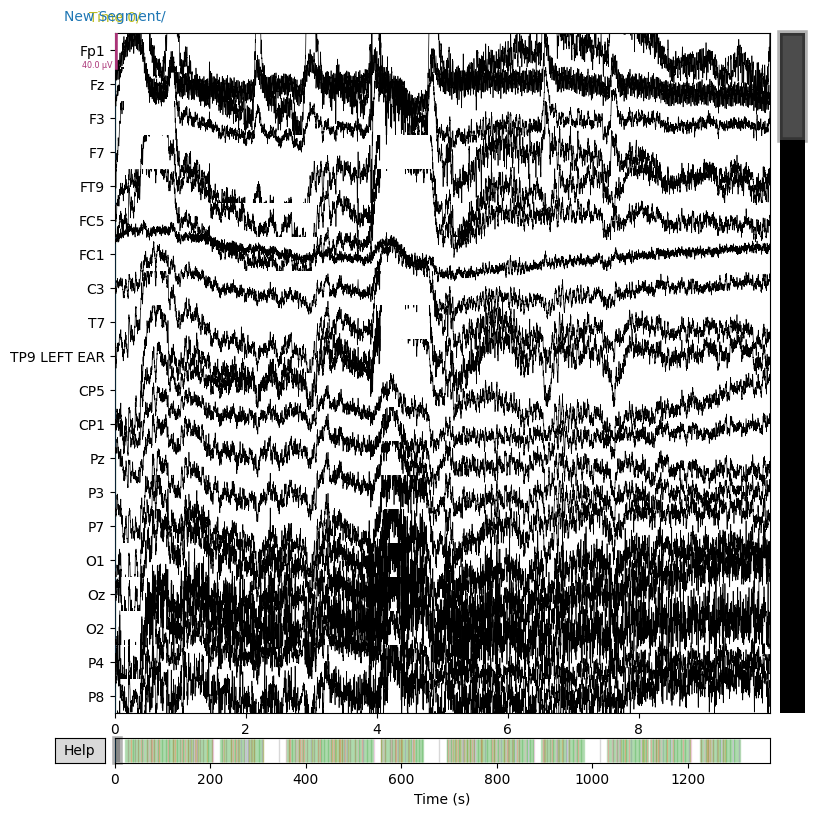

In [5]:
raw.plot()

## Tìm tần số nhiễu do điện trường

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


/tmp/ipykernel_47/3452114060.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=200)


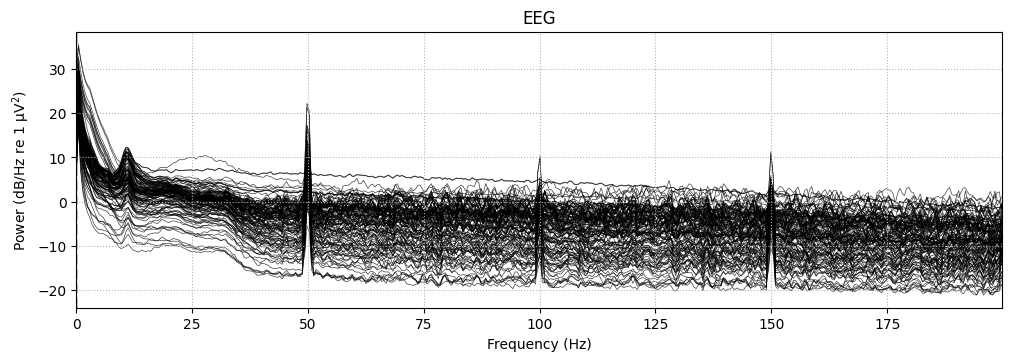

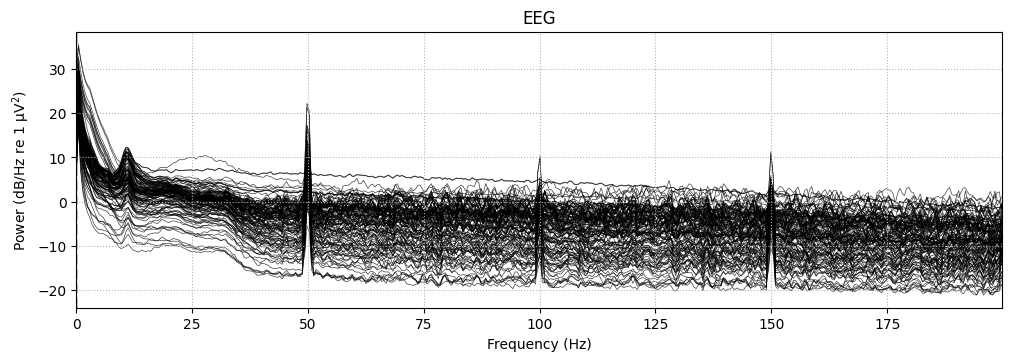

In [6]:
raw.plot_psd(fmax=200)

## ICA

### Tìm montage phù hợp

Number of channels in raw: 127
Channels (first 30): ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9 LEFT EAR', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10 RIGHT EAR', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4']
Renaming: {'TP9 LEFT EAR': 'TP9', 'TP10 RIGHT EAR': 'TP10'}
Overlap counts: {'GSN-HydroCel-129': 1, 'standard_1005': 125, 'standard_1020': 71}
Best montage candidate: standard_1005 (matched 125 channels)
Setting montage standard_1005 with 125 matched channels.


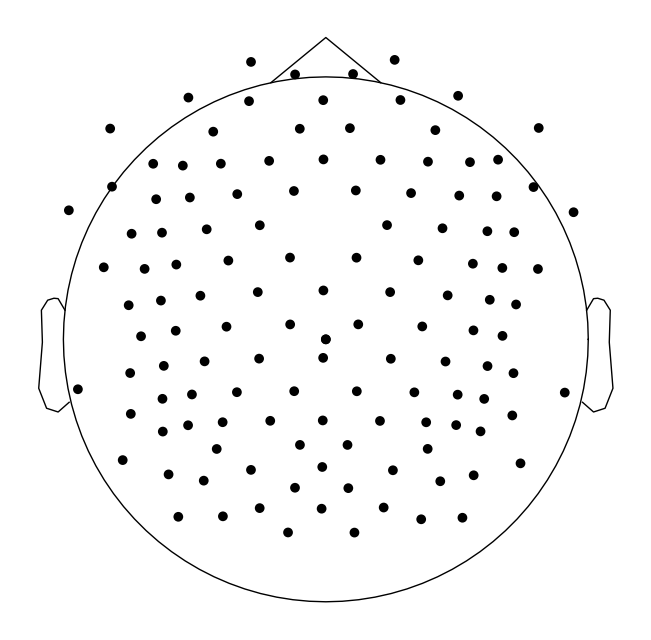

In [7]:
print("Number of channels in raw:", len(raw.ch_names))
print("Channels (first 30):", raw.ch_names[:30])

# quick rename common ear label variants
rename_map = {}
if "TP9 LEFT EAR" in raw.ch_names:
    rename_map["TP9 LEFT EAR"] = "TP9"
if "TP10 RIGHT EAR" in raw.ch_names:
    rename_map["TP10 RIGHT EAR"] = "TP10"
# add any other trivial renames if you want:
# rename_map["SomeName"] = "TargetName"

if rename_map:
    print("Renaming:", rename_map)
    raw.rename_channels(rename_map)

# candidate montages to try
candidates = ["GSN-HydroCel-129", "standard_1005", "standard_1020"]

def montage_overlap(raw, montage_name):
    try:
        mont = mne.channels.make_standard_montage(montage_name)
    except Exception as e:
        print(f"Cannot make montage {montage_name}: {e}")
        return 0, None
    mont_names = set(mont.ch_names)
    raw_names = set(raw.ch_names)
    inter = raw_names.intersection(mont_names)
    return len(inter), (mont, mont_names, inter)

scores = {}
results = {}
for cand in candidates:
    score, data = montage_overlap(raw, cand)
    scores[cand] = score
    results[cand] = data

print("Overlap counts:", scores)

# choose best montage
best = max(scores, key=lambda k: scores[k])
best_score = scores[best]
print(f"Best montage candidate: {best} (matched {best_score} channels)")

# heuristic: require at least, e.g., 0.6 * n_raw_channels matched
threshold = int(0.6 * len(raw.ch_names))

if best_score >= threshold:
    mont, mont_names, inter = results[best]
    print(f"Setting montage {best} with {best_score} matched channels.")
    raw.set_montage(mont, on_missing='ignore')
    # plot sensors to visually check
    raw.plot_sensors(kind='topomap', show_names=False)
else:
    print("Warning: no montage candidate matches sufficiently well.")
    # show top mismatches to help manual rename
    for cand in candidates:
        data = results[cand]
        if data is None:
            continue
        mont, mont_names, inter = data
        unmatched = list(set(raw.ch_names) - mont_names)
        print(f"\nMontage {cand}: matched {len(inter)} channels, unmatched (first 30):")
        print(unmatched[:30])
    print("\nYou can rename some raw channel names (e.g. 'TP9 LEFT EAR'->'TP9') or pick another montage.")
    # as a fallback, still set the best montage but with on_missing='ignore' behaviour MNE offers
    try:
        mont = mne.channels.make_standard_montage(best)
        raw.set_montage(mont, on_missing='ignore')
        print(f"Set montage {best} anyway (some channels unmapped).")
        raw.plot_sensors(kind='topomap', show_names=False)
    except Exception as e:
        print("Failed to set montage automatically:", e)

# optional: save the raw with montage to disk or continue processing
# raw.save("sub01_with_montage_raw.fif", overwrite=True)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)

Fitting ICA to data u

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


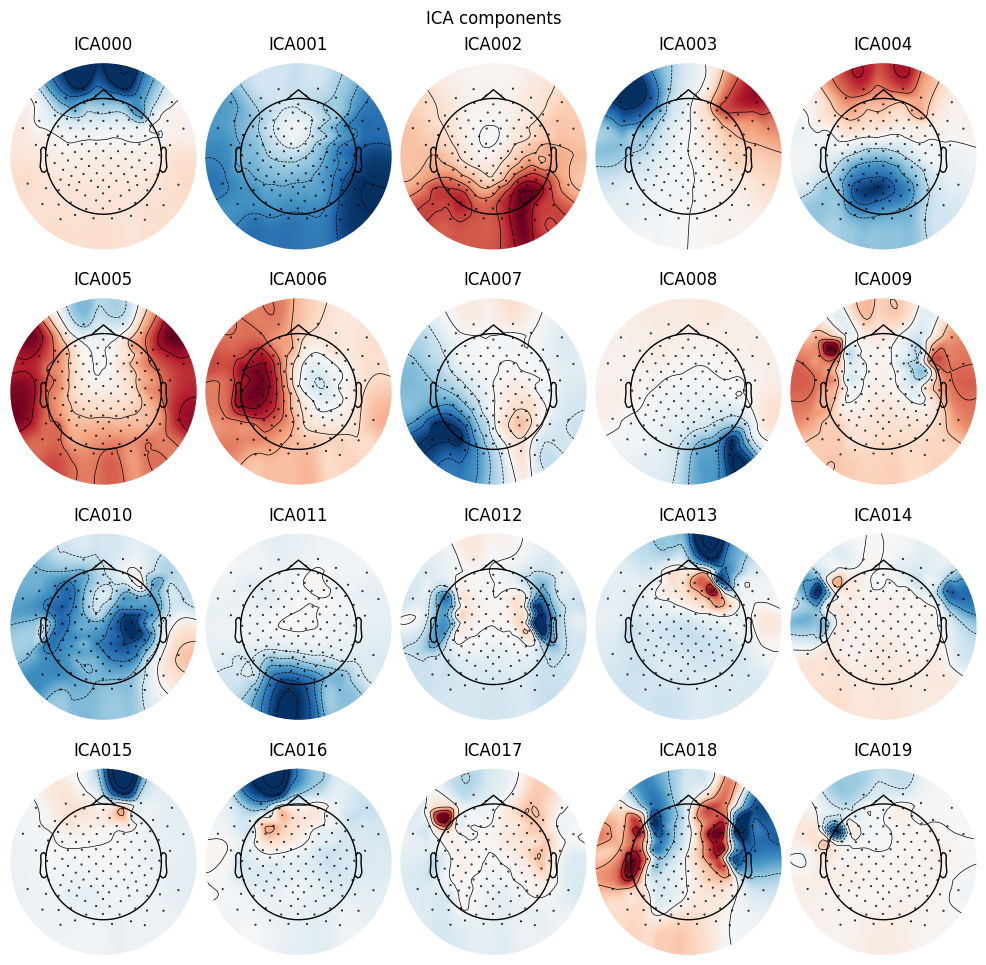

Creating RawArray with float64 data, n_channels=20, n_times=1371320
    Range : 0 ... 1371319 =      0.000 ...  1371.319 secs
Ready.


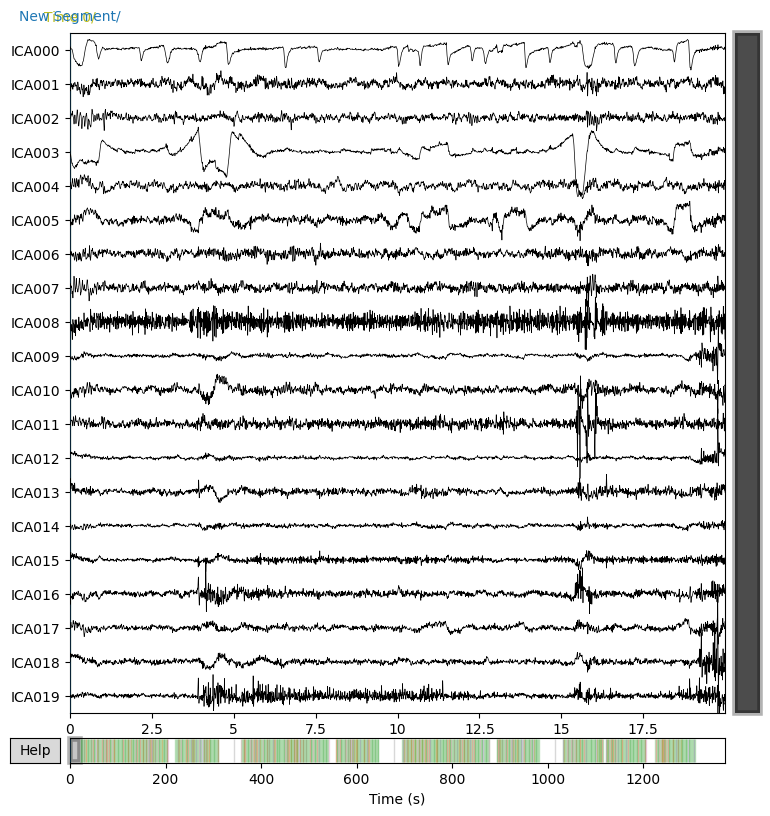

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
685 matching events found
No baseline correction applied
0 projection items activated


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Not setting metadata
685 matching events found
No baseline correction applied
0 projection items activated


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Not setting metadata
685 matching events found
No baseline correction applied
0 projection items activated


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Not setting metadata
685 matching events found
No baseline correction applied
0 projection items activated


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


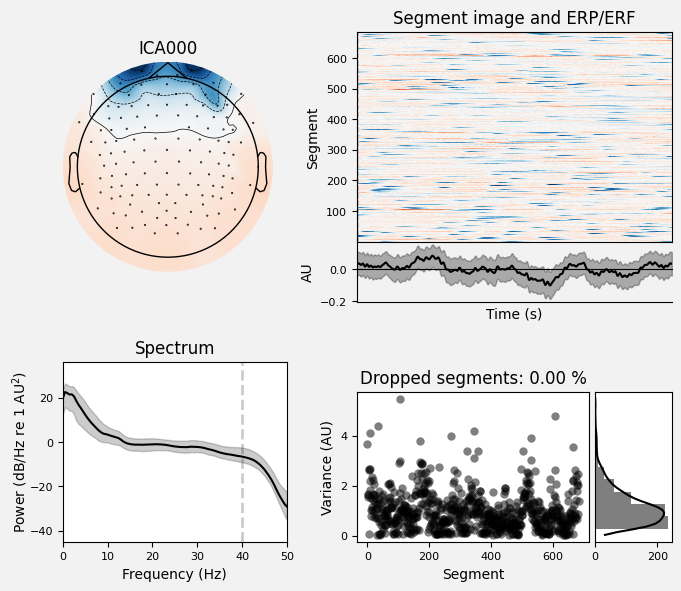

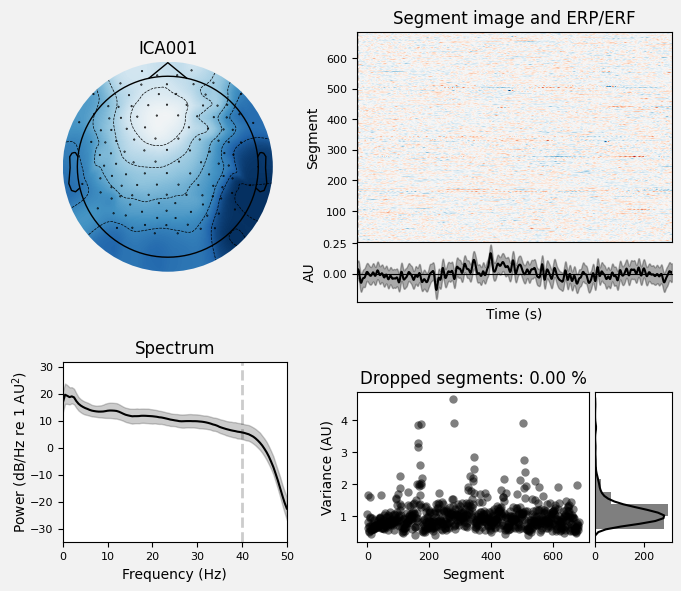

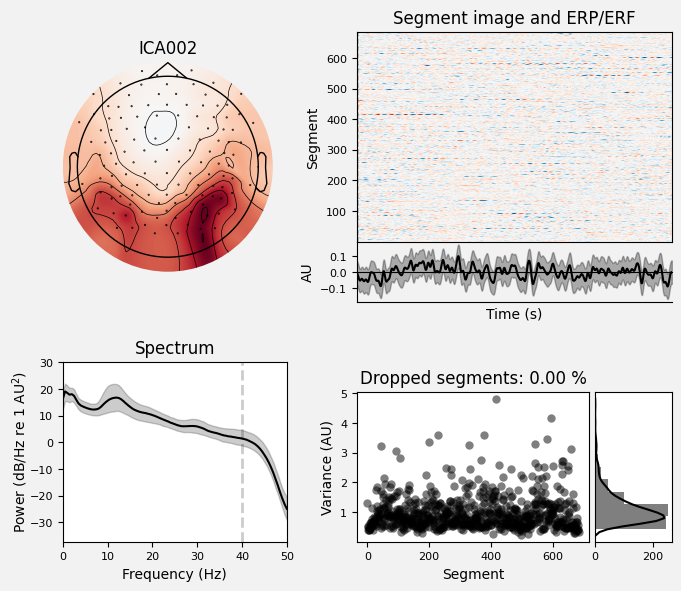

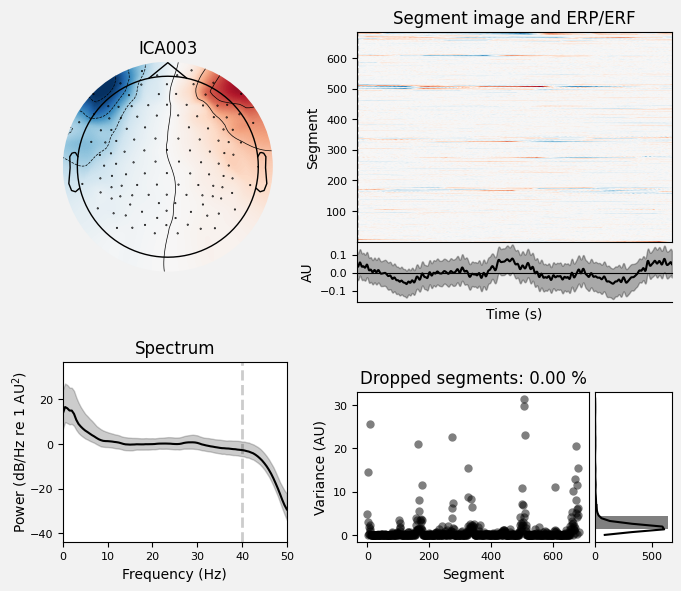

[<Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>]

In [8]:
# lọc nhẹ để ICA dễ chạy
raw.notch_filter([50, 100, 150])
raw.filter(1, 40)

raw.drop_channels(['O9', 'O10'])
raw.set_montage('standard_1005')

ica = mne.preprocessing.ICA(n_components=20, random_state=97)
ica.fit(raw)

# Vẽ component maps
ica.plot_components(inst=raw, sphere='auto')  # mở bảng 20 components

# Vẽ time-series của từng component nếu muốn
ica.plot_sources(raw)

# Vẽ topomap để xem component nhiễu mắt (blinks) hoặc cơ
ica.plot_properties(raw, picks=[0,1,2,3])  # chọn vài component để xem


In [9]:
def process_subject_folder(sub_folder, event_id, tmin=TMIN, tmax=TMAX,
                           fmin=FMIN, fmax=FMAX, target_sfreq=128):

    vhdr_files = glob(os.path.join(sub_folder, "*.vhdr"))
    if len(vhdr_files) == 0:
        raise FileNotFoundError(f"No .vhdr found in {sub_folder}")

    vhdr = vhdr_files[0]
    raw = mne.io.read_raw_brainvision(vhdr, preload=True, verbose=False)

    # --- Notch + Bandpass ---
    raw.notch_filter([50, 100], verbose=False)
    raw.filter(fmin, fmax, fir_design='firwin', verbose=False)

    # --- Re-reference ---
    raw.set_eeg_reference("average", verbose=False)

    # --- Downsample ---
    raw.resample(target_sfreq, verbose=False)

    # # --- ICA ---
    # ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter="auto")
    # ica.fit(raw)

    # # EOG
    # if len(mne.pick_types(raw.info, eog=True)) > 0:
    #     eog_inds, _ = ica.find_bads_eog(raw)
    #     ica.exclude.extend(eog_inds)
    # else:
    #     print("No EOG channel found → skipping EOG ICA step")

    # # ECG — optional
    # if len(mne.pick_types(raw.info, ecg=True)) > 0:
    #     ecg_inds, _ = ica.find_bads_ecg(raw)
    #     ica.exclude.extend(ecg_inds)
    # else:
    #     print("No ECG channel found → skipping ECG ICA step")

    # raw = ica.apply(raw)

    # Epoching
    events, event_dict = mne.events_from_annotations(raw, verbose=False)
    epochs = mne.Epochs(raw, events, event_id=event_id,
                        tmin=tmin, tmax=tmax,
                        baseline=(None, 0),
                        preload=True, verbose=False)

    if len(epochs) == 0:
        print(f"Warning: no epochs for {sub_folder}")
        return None, None, None, None, None

    X = epochs.get_data()
    y = epochs.events[:, -1]

    return X, y, epochs.times, raw.info["sfreq"], event_dict


In [10]:
# ============================
# CELL 3 — Extract event_dict
# ============================

# Load 1 subject to get event_ids
tmp_sub = subject_dirs[0]
tmp_vhdr = glob(os.path.join(tmp_sub, "*.vhdr"))[0]
tmp_raw = mne.io.read_raw_brainvision(tmp_vhdr, preload=False, verbose=False)
tmp_events, tmp_dict = mne.events_from_annotations(tmp_raw, verbose=False)

print("Event_dict:", tmp_dict)

EVENT_ID = {
    "standard": tmp_dict["Stimulus/S  5"],
    "oddball":  tmp_dict["Stimulus/S  6"]
}
print("Using EVENT_ID:", EVENT_ID)


Event_dict: {'New Segment/': 99999, 'Stimulus/S  1': 1, 'Stimulus/S  5': 5, 'Stimulus/S  6': 6, 'Stimulus/S  7': 7, 'Stimulus/S 10': 10, 'Stimulus/S 12': 12, 'Time 0/': 10001}
Using EVENT_ID: {'standard': 5, 'oddball': 6}


In [11]:
# chạy trong environment đã import mne và có tmp_raw, tmp_events, tmp_dict từ trước
import numpy as np
from collections import Counter, defaultdict

# --- cấu hình ---
response_label_in_dict = "Stimulus/S  1"   # theo tmp_dict bạn báo có S 1 là response
min_rt = 0.08   # giây, ngưỡng tối thiểu RT hợp lệ
max_rt = 1.5    # giây, ngưỡng tối đa RT hợp lệ
sfreq = tmp_raw.info['sfreq']

# --- đảo dict: từ id -> name ---
inv = {v:k for k,v in tmp_dict.items()}  # maps event_id -> annotation string

# --- tần suất của từng event id ---
event_ids = tmp_events[:,2]
counts = Counter(event_ids)
print("Counts (event_id : count) sorted:")
for eid,c in counts.most_common():
    name = inv.get(eid, str(eid))
    print(f"{eid:5d} : {c:6d}    -> {name}")

# --- tìm các sample time cho từng event id ---
events_by_id = defaultdict(list)
for sample, _, eid in tmp_events:
    events_by_id[eid].append(sample)

# --- tìm which stimulus precedes responses most often ---
# lấy id của response (nếu tồn tại trong dict)
resp_id = tmp_dict.get(response_label_in_dict, None)
if resp_id is None:
    print("\nKhông tìm thấy response id theo tên", response_label_in_dict)
else:
    preceding_counter = Counter()
    resp_samples = np.array(events_by_id[resp_id])
    # tạo list tất cả stimulus event ids (loại trừ response id và system ids)
    system_names = {"New Segment/", "Time 0/"}  # có thể mở rộng
    system_ids = {v for k,v in tmp_dict.items() if k in system_names}
    stim_candidate_ids = [eid for eid in events_by_id.keys() if eid not in system_ids and eid != resp_id]
    all_stim_samples = []
    for eid in stim_candidate_ids:
        all_stim_samples.extend([(sample, eid) for sample in events_by_id[eid]])
    # sort all stim samples by time
    all_stim_samples = sorted(all_stim_samples, key=lambda x: x[0])
    stim_samples_arr = np.array([s for s,_ in all_stim_samples])
    stim_eid_arr = np.array([eid for _,eid in all_stim_samples])
    # for each response, find nearest previous stimulus within RT window
    for rs in resp_samples:
        # compute time difference in seconds to all stim before rs
        # find last stim with sample < rs
        idx = np.searchsorted(stim_samples_arr, rs) - 1
        if idx < 0:
            continue
        stim_sample = stim_samples_arr[idx]
        dt = (rs - stim_sample) / sfreq
        if min_rt <= dt <= max_rt:
            stim_eid = stim_eid_arr[idx]
            preceding_counter[stim_eid] += 1

    print("\nStimulus IDs that precede responses (count):")
    for eid,count in preceding_counter.most_common():
        print(eid, count, "->", inv.get(eid))
    if len(preceding_counter)==0:
        print("Không tìm thấy stimulus đứng trước response trong cửa sổ RT. Có thể response id khác hoặc RT khác.")
    else:
        guessed_target_eid, _ = preceding_counter.most_common(1)[0]
        guessed_standard_eid = max([(eid, counts[eid]) for eid in events_by_id.keys()
                                    if eid not in system_ids and eid != guessed_target_eid and eid != resp_id],
                                   key=lambda x: x[1])[0]
        print("\nSuggested mapping (automatic):")
        print("target (oddball) id:", guessed_target_eid, "->", inv.get(guessed_target_eid))
        print("standard id:", guessed_standard_eid, "->", inv.get(guessed_standard_eid))

Counts (event_id : count) sorted:
    5 :    498    -> Stimulus/S  5
    1 :    107    -> Stimulus/S  1
    7 :     81    -> Stimulus/S  7
    6 :     81    -> Stimulus/S  6
   10 :      4    -> Stimulus/S 10
   12 :      3    -> Stimulus/S 12
10001 :      1    -> Time 0/
99999 :      1    -> New Segment/

Stimulus IDs that precede responses (count):
6 62 -> Stimulus/S  6
7 30 -> Stimulus/S  7
5 14 -> Stimulus/S  5

Suggested mapping (automatic):
target (oddball) id: 6 -> Stimulus/S  6
standard id: 5 -> Stimulus/S  5


In [12]:
# ============================
# CELL 4 — Load all subjects
# ============================

all_X = []
all_y = []
all_sub_idx = []

for i, sub in enumerate(subject_dirs):
    print(f"Processing {sub} ({i+1}/{len(subject_dirs)})")

    X, y, times, sfreq, evdict = process_subject_folder(sub, EVENT_ID)
    if X is None:
        continue

    all_X.append(X)
    all_y.append(y)
    all_sub_idx.append(np.full(len(y), i))

X_all = np.vstack(all_X)
y_all = np.hstack(all_y)
sub_idx_all = np.hstack(all_sub_idx)

print("Total trials:", X_all.shape)
print("Label distribution:", np.unique(y_all, return_counts=True))


Processing /kaggle/input/eeg-oddball/EEG/sub 01 (1/42)
Processing /kaggle/input/eeg-oddball/EEG/sub 02 (2/42)
Processing /kaggle/input/eeg-oddball/EEG/sub 03 (3/42)
Processing /kaggle/input/eeg-oddball/EEG/sub 04 (4/42)
Processing /kaggle/input/eeg-oddball/EEG/sub 05 (5/42)
Processing /kaggle/input/eeg-oddball/EEG/sub 06 (6/42)
Processing /kaggle/input/eeg-oddball/EEG/sub 07 (7/42)
Processing /kaggle/input/eeg-oddball/EEG/sub 08 (8/42)
Processing /kaggle/input/eeg-oddball/EEG/sub 09 (9/42)
Processing /kaggle/input/eeg-oddball/EEG/sub 10 (10/42)
Processing /kaggle/input/eeg-oddball/EEG/sub 11 (11/42)
Processing /kaggle/input/eeg-oddball/EEG/sub 12 (12/42)
Processing /kaggle/input/eeg-oddball/EEG/sub 13 (13/42)
Processing /kaggle/input/eeg-oddball/EEG/sub 14 (14/42)
Processing /kaggle/input/eeg-oddball/EEG/sub 15 (15/42)
Processing /kaggle/input/eeg-oddball/EEG/sub 16 (16/42)
Processing /kaggle/input/eeg-oddball/EEG/sub 17 (17/42)
Processing /kaggle/input/eeg-oddball/EEG/sub 18 (18/42)
P

# Feature Extraction

## Extraction of ERP Features by Computing Mean Amplitude in the P300 Time Window (250–350 ms)

In [13]:
# Convert labels to 0/1
label_map = {
    list(EVENT_ID.values())[0]: 0,
    list(EVENT_ID.values())[1]: 1
}
y_bin = np.array([label_map[v] for v in y_all])

# P300 ERP mean amplitude
t = times
mask = (t >= P300_WINDOW[0]) & (t <= P300_WINDOW[1])

def extract_erp_features(X):
    seg_mean = X[:, :, mask].mean(axis=2)
    return seg_mean.reshape(seg_mean.shape[0], -1)

X_feat = extract_erp_features(X_all)
print("ERP feature shape:", X_feat.shape)


ERP feature shape: (24440, 127)


## Hidden Markov Model (HMM) Feature Extraction on EEG Data Using PCA-Reduced Time Series

In [14]:
# ============================
# CELL 5b — HMM Feature Extraction
# ============================

N_STATES = 4      # số hidden states
N_PCA = 5         # số chiều PCA cho HMM

print("\n=== Extracting HMM features ===")

# ---- Step 1: PCA across each trial (flatten ch × time) ----
X_flat = X_all.reshape(X_all.shape[0], -1)
pca = PCA(n_components=N_PCA)
X_pca = pca.fit_transform(X_flat)

# reshape lại thành chuỗi time series cho HMM
X_seq = X_pca.reshape(X_all.shape[0], -1, 1)  # shape: (trials, time', 1)

# ---- Step 2: Train 1 global HMM for all data ----
X_concat = np.vstack([x for x in X_seq])    # concatenate into (T_total, 1)
lengths = [len(x) for x in X_seq]           # sequence lengths

hmm_model = hmm.GaussianHMM(
    n_components=N_STATES,
    covariance_type="diag",
    n_iter=100,
    random_state=RANDOM_STATE
)

print("Training HMM...")
hmm_model.fit(X_concat, lengths)

# ---- Step 3: Extract HMM features for each trial ----
def extract_hmm_features(model, X_seq):
    feats = []
    for seq in X_seq:
        ll = model.score(seq)  # log-likelihood
        states = model.predict(seq)
        # state fraction
        frac = np.bincount(states, minlength=model.n_components) / len(states)
        # transition prob flatten
        trans = model.transmat_.flatten()
        f = np.concatenate([[ll], frac, trans])
        feats.append(f)
    return np.array(feats)

X_hmm = extract_hmm_features(hmm_model, X_seq)
print("HMM feature shape:", X_hmm.shape)

# ---- Step 4: Combine ERP + HMM features ----
X_feat_hmm = np.concatenate([X_feat, X_hmm], axis=1)
print("Final feature shape:", X_feat_hmm.shape)



=== Extracting HMM features ===
Training HMM...


Model is not converging.  Current: 720697.0846711161 is not greater than 720825.4929787025. Delta is -128.40830758644734


HMM feature shape: (24440, 21)
Final feature shape: (24440, 148)


# ML training & Balance data

In [28]:
# ============================
# CELL 6 — Train ML models
# ============================

n_sub = len(subject_dirs)

train_subs = np.arange(0, 36)
test_subs  = np.arange(36, n_sub)

train_mask = np.isin(sub_idx_all, train_subs)
test_mask  = np.isin(sub_idx_all, test_subs)

X_train = X_feat[train_mask]
y_train = y_bin[train_mask]

X_test = X_feat[test_mask]
y_test = y_bin[test_mask]

from collections import Counter
import numpy as np

# Count classes
c = Counter(y_train)
minority = 1
majority = 0

n_min = c[minority]

# indices for each class
idx_min = np.where(y_train == minority)[0]
idx_maj = np.where(y_train == majority)[0]

# random undersample majority
np.random.seed(42)
idx_maj_under = np.random.choice(idx_maj, size=n_min, replace=False)

# combine
idx_bal = np.concatenate([idx_min, idx_maj_under])
np.random.shuffle(idx_bal)

X_train_bal = X_train[idx_bal]
y_train_bal = y_train[idx_bal]

print("Balanced:", Counter(y_train_bal))


scaler = StandardScaler().fit(X_train_bal)
X_train_s = scaler.transform(X_train_bal)
X_test_s = scaler.transform(X_test)

# Logistic Regression
print("\n--- Logistic Regression ---")
clf_lr = LogisticRegression(max_iter=1000,class_weight='balanced')
clf_lr.fit(X_train_s, y_train_bal)
pred_lr = clf_lr.predict(X_test_s)
print("Accuracy:", accuracy_score(y_test, pred_lr))
print(classification_report(y_test, pred_lr))

# Random Forest
print("\n--- Random Forest ---")
clf_rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)
clf_rf.fit(X_train_s, y_train_bal)
pred_rf = clf_rf.predict(X_test_s)
print("Accuracy:", accuracy_score(y_test, pred_rf))
print(classification_report(y_test, pred_rf))

# SVM RBF
print("\n--- SVM (RBF Kernel) ---")
clf_svm = SVC(kernel="rbf", C=1.0, gamma="scale", class_weight="balanced")
clf_svm.fit(X_train_s, y_train_bal)
pred_svm = clf_svm.predict(X_test_s)
print("Accuracy:", accuracy_score(y_test, pred_svm))
print(classification_report(y_test, pred_svm))


# Gradient Boosting
print("\n--- Gradient Boosting ---")
clf_gb = GradientBoostingClassifier()
clf_gb.fit(X_train_bal, y_train_bal)  # Tree-based models không cần scale
pred_gb = clf_gb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, pred_gb))
print(classification_report(y_test, pred_gb))


# XGBoost
print("\n--- XGBoost ---")
try:
    clf_xgb = XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        eval_metric="logloss"
    )
    clf_xgb.fit(X_train_bal, y_train_bal)
    pred_xgb = clf_xgb.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, pred_xgb))
    print(classification_report(y_test, pred_xgb))
except:
    print("⚠️ XGBoost không khả dụng trên môi trường này.")


# LDA
print("\n--- LDA (Linear Discriminant Analysis) ---")
clf_lda = LinearDiscriminantAnalysis()
clf_lda.fit(X_train_s, y_train_bal)
pred_lda = clf_lda.predict(X_test_s)
print("Accuracy:", accuracy_score(y_test, pred_lda))
print(classification_report(y_test, pred_lda))


Balanced: Counter({0: 2921, 1: 2921})

--- Logistic Regression ---
Accuracy: 0.7500699692135461
              precision    recall  f1-score   support

           0       0.93      0.77      0.84      3072
           1       0.31      0.65      0.42       501

    accuracy                           0.75      3573
   macro avg       0.62      0.71      0.63      3573
weighted avg       0.84      0.75      0.78      3573


--- Random Forest ---
Accuracy: 0.8029666946543521
              precision    recall  f1-score   support

           0       0.93      0.83      0.88      3072
           1       0.38      0.61      0.47       501

    accuracy                           0.80      3573
   macro avg       0.65      0.72      0.67      3573
weighted avg       0.85      0.80      0.82      3573


--- SVM (RBF Kernel) ---
Accuracy: 0.8052057094878253
              precision    recall  f1-score   support

           0       0.93      0.84      0.88      3072
           1       0.38      0.61 

In [30]:
# ============================
# CELL 6b — Train ML models with HMM
# ============================

X_train = X_feat_hmm[train_mask]
y_train = y_bin[train_mask]

X_test = X_feat_hmm[test_mask]
y_test = y_bin[test_mask]

from collections import Counter
import numpy as np

# Count classes
c = Counter(y_train)
minority = 1
majority = 0

n_min = c[minority]

# indices for each class
idx_min = np.where(y_train == minority)[0]
idx_maj = np.where(y_train == majority)[0]

# random undersample majority
np.random.seed(42)
idx_maj_under = np.random.choice(idx_maj, size=n_min, replace=False)

# combine
idx_bal = np.concatenate([idx_min, idx_maj_under])
np.random.shuffle(idx_bal)

X_train_bal = X_train[idx_bal]
y_train_bal = y_train[idx_bal]

print("Balanced:", Counter(y_train_bal))

scaler = StandardScaler().fit(X_train_bal)
X_train_s = scaler.transform(X_train_bal)
X_test_s = scaler.transform(X_test)

# Logistic Regression
print("\n--- Logistic Regression ---")
clf_lr = LogisticRegression(max_iter=1000)
clf_lr.fit(X_train_s, y_train_bal)
pred_lr = clf_lr.predict(X_test_s)
print("Accuracy:", accuracy_score(y_test, pred_lr))
print(classification_report(y_test, pred_lr))

# Random Forest
print("\n--- Random Forest ---")
clf_rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)
clf_rf.fit(X_train_s, y_train_bal)
pred_rf = clf_rf.predict(X_test_s)
print("Accuracy:", accuracy_score(y_test, pred_rf))
print(classification_report(y_test, pred_rf))

# SVM RBF
print("\n--- SVM (RBF Kernel) ---")
clf_svm = SVC(kernel="rbf", C=1.0, gamma="scale")
clf_svm.fit(X_train_s, y_train_bal)
pred_svm = clf_svm.predict(X_test_s)
print("Accuracy:", accuracy_score(y_test, pred_svm))
print(classification_report(y_test, pred_svm))


# Gradient Boosting
print("\n--- Gradient Boosting ---")
clf_gb = GradientBoostingClassifier()
clf_gb.fit(X_train_bal, y_train_bal)  # Tree-based models không cần scale
pred_gb = clf_gb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, pred_gb))
print(classification_report(y_test, pred_gb))


# XGBoost
print("\n--- XGBoost ---")
try:
    clf_xgb = XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        eval_metric="logloss"
    )
    clf_xgb.fit(X_train_bal, y_train_bal)
    pred_xgb = clf_xgb.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, pred_xgb))
    print(classification_report(y_test, pred_xgb))
except:
    print("⚠️ XGBoost không khả dụng trên môi trường này.")


# LDA
print("\n--- LDA (Linear Discriminant Analysis) ---")
clf_lda = LinearDiscriminantAnalysis()
clf_lda.fit(X_train_s, y_train_bal)
pred_lda = clf_lda.predict(X_test_s)
print("Accuracy:", accuracy_score(y_test, pred_lda))
print(classification_report(y_test, pred_lda))


Balanced: Counter({0: 2921, 1: 2921})

--- Logistic Regression ---
Accuracy: 0.7441925552756787
              precision    recall  f1-score   support

           0       0.93      0.76      0.84      3072
           1       0.31      0.65      0.42       501

    accuracy                           0.74      3573
   macro avg       0.62      0.71      0.63      3573
weighted avg       0.84      0.74      0.78      3573


--- Random Forest ---
Accuracy: 0.7970892807164848
              precision    recall  f1-score   support

           0       0.93      0.83      0.88      3072
           1       0.37      0.62      0.46       501

    accuracy                           0.80      3573
   macro avg       0.65      0.72      0.67      3573
weighted avg       0.85      0.80      0.82      3573


--- SVM (RBF Kernel) ---
Accuracy: 0.8066050937587461
              precision    recall  f1-score   support

           0       0.93      0.84      0.88      3072
           1       0.38      0.61 

# DL training 

In [31]:
# ============================
# CELL 7 — Prepare DL inputs
# ============================

X_dl = X_all.astype(np.float32)
train_indices = np.where(train_mask)[0]
test_indices  = np.where(test_mask)[0]

from torch.utils.data import WeightedRandomSampler

# Balanced sampler
y_train_dl = y_bin[train_indices]

class_sample_count = np.array([
    len(np.where(y_train_dl == t)[0]) for t in np.unique(y_train_dl)
])

weights = 1. / class_sample_count
sample_weights = np.array([weights[t] for t in y_train_dl])

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# Normalize ONLY using train subjects
ch_mean = X_dl[train_indices].mean(axis=(0,2))
ch_std  = X_dl[train_indices].std(axis=(0,2)) + 1e-9

for c in range(X_dl.shape[1]):
    X_dl[:, c, :] = (X_dl[:, c, :] - ch_mean[c]) / ch_std[c]

# Add dimension for Conv2D: (N, 1, C, T)
X_dl = X_dl[:, np.newaxis, :, :]

# Dataset class
class EEGDataset(Dataset):
    def __init__(self, X, y, indices):
        self.X = torch.from_numpy(X[indices])
        self.y = torch.from_numpy(y[indices].astype(np.int64))
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = EEGDataset(X_dl, y_bin, train_indices)
test_dataset  = EEGDataset(X_dl, y_bin, test_indices)

# ❗❗ USE SAMPLER for balanced training ❗❗
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)



In [32]:
# ============================
# CELL 8 — EEGNet model
# ============================

class SimpleEEGNet(nn.Module):
    def __init__(self, in_ch, n_times, n_classes=2, F1=8, D=2):
        super().__init__()
        self.temp_conv = nn.Conv2d(1, F1, kernel_size=(1, 64),
                                   padding=(0,32), bias=False)
        self.bn1 = nn.BatchNorm2d(F1)

        self.depthwise = nn.Conv2d(F1, F1*D, kernel_size=(in_ch,1),
                                   groups=F1, bias=False)
        self.bn2 = nn.BatchNorm2d(F1*D)

        self.pool = nn.AvgPool2d((1,4))
        self.drop = nn.Dropout(0.5)

        out_time = n_times // 4
        self.classify = nn.Sequential(
            nn.Flatten(),
            nn.Linear(F1*D * out_time, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, n_classes)
        )

    def forward(self, x):
        x = torch.relu(self.bn1(self.temp_conv(x)))
        x = torch.relu(self.bn2(self.depthwise(x)))
        x = self.pool(x)
        x = self.drop(x)
        return self.classify(x)

In [33]:
# ============================
# CELL 8b — ShallowConvNet model
# ============================
class ShallowConvNet(nn.Module):
    def __init__(self, in_ch, n_times, n_classes=2):
        super().__init__()

        # Temporal convolution
        self.conv_time = nn.Conv2d(
            1, 40, kernel_size=(1, 25), stride=1, padding=(0, 12), bias=False
        )
        self.bn_time = nn.BatchNorm2d(40)

        # Spatial convolution (depthwise)
        self.conv_spat = nn.Conv2d(
            40, 40, kernel_size=(in_ch, 1), groups=40, bias=False
        )
        self.bn_spat = nn.BatchNorm2d(40)

        # Mean Pooling with big kernel (the original paper uses 75)
        self.pool = nn.AvgPool2d(kernel_size=(1, 75), stride=(1, 15))

        # Compute output size dynamically
        dummy = torch.zeros(1, 1, in_ch, n_times)
        out = self._forward_features(dummy)
        self.flatten_dim = out.numel()

        self.classifier = nn.Linear(self.flatten_dim, n_classes)

    def _forward_features(self, x):
        x = self.conv_time(x)
        x = self.bn_time(x)

        x = self.conv_spat(x)
        x = self.bn_spat(x)

        x = x ** 2                         # Square activation
        x = self.pool(x)
        x = torch.log(torch.clamp(x, min=1e-6))  # Log activation
        return x

    def forward(self, x):
        x = self._forward_features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

In [34]:
# ============================
# CELL 8c — DeepConvNet model
# ============================
class DeepConvNet(nn.Module):
    def __init__(self, in_ch, n_times, n_classes=2, dropout=0.5):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(1, 25, kernel_size=(1, 5), stride=1, padding=(0, 2), bias=False),
            nn.Conv2d(25, 25, kernel_size=(in_ch, 1), groups=25, bias=False),
            nn.BatchNorm2d(25),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2)),
            nn.Dropout(dropout),
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(25, 50, kernel_size=(1, 5), padding=(0, 2), bias=False),
            nn.BatchNorm2d(50),
            nn.ELU(),
            nn.MaxPool2d((1, 2)),
            nn.Dropout(dropout),
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(50, 100, kernel_size=(1, 5), padding=(0, 2), bias=False),
            nn.BatchNorm2d(100),
            nn.ELU(),
            nn.MaxPool2d((1, 2)),
            nn.Dropout(dropout),
        )

        self.block4 = nn.Sequential(
            nn.Conv2d(100, 200, kernel_size=(1, 5), padding=(0, 2), bias=False),
            nn.BatchNorm2d(200),
            nn.ELU(),
            nn.MaxPool2d((1, 2)),
            nn.Dropout(dropout),
        )

        # Compute feature dimensions
        dummy = torch.zeros(1, 1, in_ch, n_times)
        out = self._forward_features(dummy)
        self.flatten_dim = out.numel()

        self.classifier = nn.Linear(self.flatten_dim, n_classes)

    def _forward_features(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        return x

    def forward(self, x):
        x = self._forward_features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

In [35]:
# ============================
# CELL 9 — Train DL model
# ============================
n_channels = X_dl.shape[2]
n_times = X_dl.shape[3]
models = {
    "EEGNet": SimpleEEGNet(n_channels, n_times).to(DEVICE),
    "ShallowConvNet": ShallowConvNet(n_channels, n_times).to(DEVICE),
    "DeepConvNet": DeepConvNet(n_channels, n_times).to(DEVICE),
}

In [36]:
# ============================
# CELL 9 — Train DL model
# ============================
import matplotlib.pyplot as plt

def train_one_model(model, name, train_loader, test_loader, epochs=EPOCHS, lr=LEARNING_RATE):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_acc = 0
    best_path = f"best_{name}.pth"

    # --------------------------
    # Lists để lưu loss/acc
    # --------------------------
    epoch_loss = []
    epoch_acc = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for xb, yb in train_loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)

            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * xb.size(0)

        # ===== Evaluation =====
        model.eval()
        preds, labels = [], []

        with torch.no_grad():
            for xb, yb in test_loader:
                xb = xb.to(DEVICE)
                out = model(xb)
                p = out.argmax(1).cpu().numpy()
                preds.append(p)
                labels.append(yb.numpy())

        preds = np.concatenate(preds)
        labels = np.concatenate(labels)
        acc = (preds == labels).mean()

        avg_loss = total_loss / len(train_loader.dataset)
        print(f"[{name}] Epoch {epoch+1}/{epochs}  Loss={avg_loss:.4f}  Acc={acc:.4f}")

        # Lưu vào list
        epoch_loss.append(avg_loss)
        epoch_acc.append(acc)

        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), best_path)

    print(f"Best accuracy for {name}: {best_acc:.4f}\n")

    # --------------------------
    # Vẽ biểu đồ Loss & Accuracy
    # --------------------------
    fig, ax1 = plt.subplots(figsize=(8,5))

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color='tab:red')
    ax1.plot(range(1, epochs+1), epoch_loss, color='tab:red', label='Loss')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel("Accuracy", color='tab:blue')
    ax2.plot(range(1, epochs+1), epoch_acc, color='tab:blue', label='Accuracy')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    fig.suptitle(f"Training Loss & Accuracy for {name}")
    fig.tight_layout()
    plt.show()

    return best_acc, epoch_loss, epoch_acc


Training model: EEGNet
[EEGNet] Epoch 1/30  Loss=0.4265  Acc=0.8844
[EEGNet] Epoch 2/30  Loss=0.3156  Acc=0.8925
[EEGNet] Epoch 3/30  Loss=0.2861  Acc=0.9104
[EEGNet] Epoch 4/30  Loss=0.2665  Acc=0.8844
[EEGNet] Epoch 5/30  Loss=0.2461  Acc=0.9141
[EEGNet] Epoch 6/30  Loss=0.2390  Acc=0.9312
[EEGNet] Epoch 7/30  Loss=0.2239  Acc=0.8886
[EEGNet] Epoch 8/30  Loss=0.2137  Acc=0.9214
[EEGNet] Epoch 9/30  Loss=0.2071  Acc=0.9116
[EEGNet] Epoch 10/30  Loss=0.2084  Acc=0.9082
[EEGNet] Epoch 11/30  Loss=0.2011  Acc=0.9230
[EEGNet] Epoch 12/30  Loss=0.1994  Acc=0.9264
[EEGNet] Epoch 13/30  Loss=0.1910  Acc=0.9135
[EEGNet] Epoch 14/30  Loss=0.1838  Acc=0.8939
[EEGNet] Epoch 15/30  Loss=0.1917  Acc=0.9270
[EEGNet] Epoch 16/30  Loss=0.1919  Acc=0.9292
[EEGNet] Epoch 17/30  Loss=0.1843  Acc=0.9088
[EEGNet] Epoch 18/30  Loss=0.1760  Acc=0.9331
[EEGNet] Epoch 19/30  Loss=0.1781  Acc=0.9158
[EEGNet] Epoch 20/30  Loss=0.1726  Acc=0.9256
[EEGNet] Epoch 21/30  Loss=0.1748  Acc=0.9068
[EEGNet] Epoch 22/30

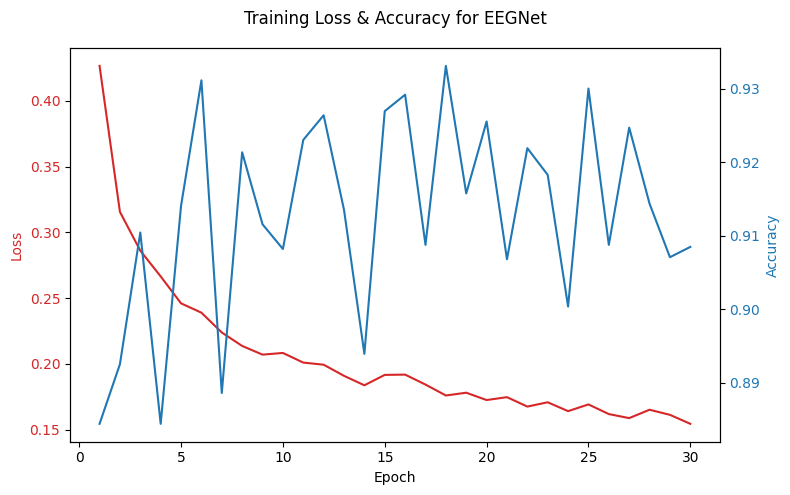

Training model: ShallowConvNet
[ShallowConvNet] Epoch 1/30  Loss=0.4617  Acc=0.8651
[ShallowConvNet] Epoch 2/30  Loss=0.3068  Acc=0.8880
[ShallowConvNet] Epoch 3/30  Loss=0.2624  Acc=0.8763
[ShallowConvNet] Epoch 4/30  Loss=0.2399  Acc=0.8477
[ShallowConvNet] Epoch 5/30  Loss=0.2290  Acc=0.8601
[ShallowConvNet] Epoch 6/30  Loss=0.2128  Acc=0.8122
[ShallowConvNet] Epoch 7/30  Loss=0.2088  Acc=0.8408
[ShallowConvNet] Epoch 8/30  Loss=0.1845  Acc=0.8634
[ShallowConvNet] Epoch 9/30  Loss=0.1842  Acc=0.8964
[ShallowConvNet] Epoch 10/30  Loss=0.1717  Acc=0.8634
[ShallowConvNet] Epoch 11/30  Loss=0.1611  Acc=0.8573
[ShallowConvNet] Epoch 12/30  Loss=0.1557  Acc=0.8623
[ShallowConvNet] Epoch 13/30  Loss=0.1556  Acc=0.8472
[ShallowConvNet] Epoch 14/30  Loss=0.1676  Acc=0.8139
[ShallowConvNet] Epoch 15/30  Loss=0.1432  Acc=0.8556
[ShallowConvNet] Epoch 16/30  Loss=0.1459  Acc=0.8206
[ShallowConvNet] Epoch 17/30  Loss=0.1324  Acc=0.8335
[ShallowConvNet] Epoch 18/30  Loss=0.1292  Acc=0.8251
[Shall

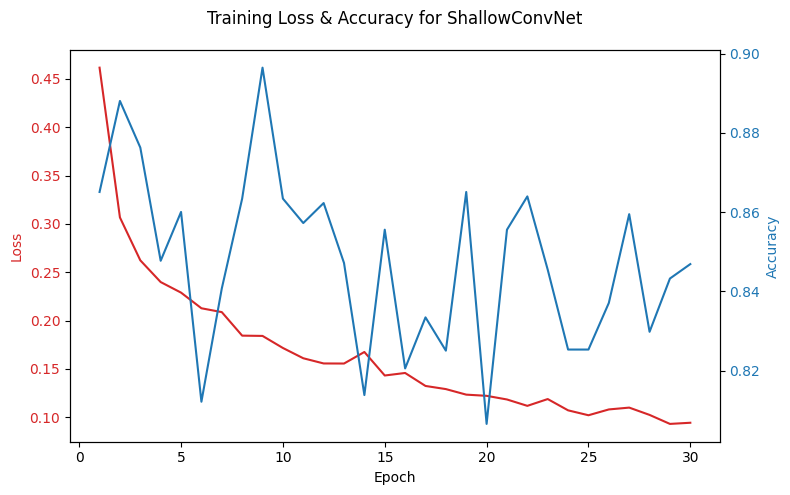

Training model: DeepConvNet
[DeepConvNet] Epoch 1/30  Loss=0.4413  Acc=0.8561
[DeepConvNet] Epoch 2/30  Loss=0.3352  Acc=0.9264
[DeepConvNet] Epoch 3/30  Loss=0.3047  Acc=0.9219
[DeepConvNet] Epoch 4/30  Loss=0.2910  Acc=0.9292
[DeepConvNet] Epoch 5/30  Loss=0.2731  Acc=0.8240
[DeepConvNet] Epoch 6/30  Loss=0.2526  Acc=0.9216
[DeepConvNet] Epoch 7/30  Loss=0.2530  Acc=0.9421
[DeepConvNet] Epoch 8/30  Loss=0.2388  Acc=0.9284
[DeepConvNet] Epoch 9/30  Loss=0.2434  Acc=0.9395
[DeepConvNet] Epoch 10/30  Loss=0.2342  Acc=0.9320
[DeepConvNet] Epoch 11/30  Loss=0.2225  Acc=0.9244
[DeepConvNet] Epoch 12/30  Loss=0.2194  Acc=0.9230
[DeepConvNet] Epoch 13/30  Loss=0.2142  Acc=0.9373
[DeepConvNet] Epoch 14/30  Loss=0.2037  Acc=0.9348
[DeepConvNet] Epoch 15/30  Loss=0.2084  Acc=0.9342
[DeepConvNet] Epoch 16/30  Loss=0.2087  Acc=0.9236
[DeepConvNet] Epoch 17/30  Loss=0.2125  Acc=0.9317
[DeepConvNet] Epoch 18/30  Loss=0.2020  Acc=0.9353
[DeepConvNet] Epoch 19/30  Loss=0.1945  Acc=0.9250
[DeepConvNet

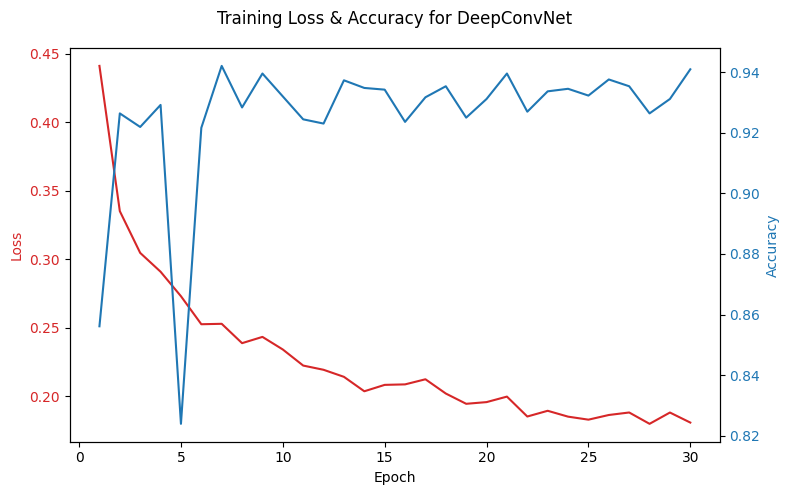

In [37]:
# ============================
# CELL 9 — Train DL model
# ============================
results = {}

for name, model in models.items():
    print("========================================")
    print(f"Training model: {name}")
    print("========================================")
    acc = train_one_model(model, name, train_loader, test_loader,
                          epochs=EPOCHS, lr=LEARNING_RATE)
    results[name] = acc

In [38]:
# ============================
# CELL 10 — Evaluate + Save
# ============================
def evaluate_model(model, checkpoint_path, test_loader, device):
    # Load lại trọng số của model
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()

    preds, labels = [], []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            out = model(xb)
            p = out.argmax(1).cpu().numpy()

            preds.append(p)
            labels.append(yb.numpy())

    preds = np.concatenate(preds)
    labels = np.concatenate(labels)

    acc = accuracy_score(labels, preds)
    print("Final Accuracy:", acc)
    print(classification_report(labels, preds))
    print(confusion_matrix(labels, preds))

    return acc

In [39]:
# ============================
# CELL 10 — Evaluate + Save
# ============================

model_paths = {
    "EEGNet": "best_EEGNet.pth",
    "Shallow": "best_ShallowConvNet.pth",
    "DeepConvNet": "best_DeepConvNet.pth"
}

for name, path in model_paths.items():
    print("\n===== Evaluating", name, "=====")

    # tạo model tương ứng
    if name == "EEGNet":
        model = SimpleEEGNet(n_channels, n_times).to(DEVICE)
    elif name == "Shallow":
        model = ShallowConvNet(n_channels, n_times).to(DEVICE)
    elif name == "DeepConvNet":
        model = DeepConvNet(n_channels, n_times).to(DEVICE)

    evaluate_model(model, path, test_loader, DEVICE)

import joblib
joblib.dump(clf_lr, "logreg.pkl")
joblib.dump(clf_rf, "rf.pkl")
joblib.dump(clf_svm,"svm.pkl")
joblib.dump(clf_gb,"gb.pkl")
joblib.dump(clf_xgb,"xgb.pkl")
joblib.dump(clf_lda,"lda.pkl")
joblib.dump(scaler, "scaler.pkl")

print("Saved: logreg.pkl, rf.pkl, svm.pkl, gb.pkl, xgb.pkl, lda.pkl, best_EEGNet.pth, best_ShallowConvNet.pth, best_DeepConvNet.pth")


===== Evaluating EEGNet =====
Final Accuracy: 0.933109431849986
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      3072
           1       0.75      0.79      0.77       501

    accuracy                           0.93      3573
   macro avg       0.86      0.88      0.86      3573
weighted avg       0.94      0.93      0.93      3573

[[2936  136]
 [ 103  398]]

===== Evaluating Shallow =====
Final Accuracy: 0.8964455639518611
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      3072
           1       0.60      0.77      0.67       501

    accuracy                           0.90      3573
   macro avg       0.78      0.84      0.81      3573
weighted avg       0.91      0.90      0.90      3573

[[2819  253]
 [ 117  384]]

===== Evaluating DeepConvNet =====
Final Accuracy: 0.9420654911838791
              precision    recall  f1-score   support

           0       0.97      0.96 